## Import libraries

In [1]:
# basic staff
import numpy as np
import pandas as pd
import seaborn as sns

# need for learning and drawing
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

# some datasets
from keras.datasets import mnist
from sklearn.datasets import load_digits

# oh GOD faster please
from os import environ
environ['OMP_NUM_THREADS'] = '4'

## Create Activation Functions

In [2]:
class Sigmoid:
    
    def __init__(self, name='sigmoid'):
        self.name = name
        
    def func(self, x):
        
        # positive values and zeros
        pos_values = np.copy(x)
        pos_values = 1.0 / (1.0 + np.exp(-pos_values))
        pos_values[x < 0.0] = 0.0
        
        # negative values
        neg_values = np.copy(x)
        neg_values = np.exp(neg_values) / (1.0 + np.exp(neg_values))
        neg_values[x >= 0.0] = 0.0
        
        # return the sum !!!
        return pos_values + neg_values
        
    def deriv(self, x):
        return x * (1 - x)
    
class Tanh:
    
    def __init__(self, name='tanh'):
        self.name = name
        
    def func(self, x):
        return np.tanh(x)
        
    def deriv(self, x):
        return 1 - x ** 2
    
class Linear:
    
    def __init__(self, name='linear'):
        self.name = name
        
    def func(self, x):
        return x
        
    def deriv(self, x):
        return np.ones(x.shape)
    
class Relu:
    
    def __init__(self, name='relu'):
        self.name = name
        
    def func(self, x):
        tmp = np.copy(x)
        tmp[tmp < 0.0] = 0.0
        
        return tmp
        
    def deriv(self, x):
        tmp = np.copy(x) > 0
        tmp = np.array(tmp, dtype=int)
        
        return tmp
    
class Softmax:
    
    def __init__(self, name='softmax'):
        self.name = name
        
    def func(self, x):
        
        result = x - np.max(x, axis=0)
        
        result = np.exp(result)
        result = result / np.sum(result, axis=0)
        
        return result
        
    def deriv(self, x):          
        return x * (1 - x)

def get_func(name):
    
    func = None
    
    if name == 'tanh':
        func = Tanh()
    
    elif name == 'relu':
        func = Relu()
        
    elif name == 'linear':
        func = Linear()
    
    elif name == 'softmax':
        func = Softmax()  
        
    else:
        func = Sigmoid()
        
    return func

## Layer and Network implementation

### Simple full-connected layer

In [3]:
class Layer:
    
    def __init__(self, n, i_n, activation='sigmoid', lr=None):
        self.n = n
        self.i_n = i_n
        self.activ = get_func(activation)
        self.lr = lr
        
        self.matrix = np.random.normal(size=(n, i_n), scale=0.1)
        self.bias = np.random.normal(size=(n, 1), scale=0.1)
            
    def forward(self, x):
        self.input = np.copy(x)
        self.result = self.activ.func(np.dot(self.matrix, self.input) + self.bias)
        return np.copy(self.result)
    
    def backward(self, sensitivity, lr):
        
        deriv_vect = self.activ.deriv(self.result)
        sensitivity = sensitivity * deriv_vect
        
        update_data = {}
        update_data['d_matrix'] = np.dot(sensitivity, self.input.T) / self.input.shape[1]
        update_data['d_bias'] =  np.sum(sensitivity, axis=1).reshape((-1, 1)) / self.input.shape[1]
        
        sensitivity = np.dot(self.matrix.T, sensitivity)
        
        self.input, self.result = None, None
        self.update(update_data, lr)
        
        return sensitivity
    
    def update(self, data, p_lr):
        
        lr = self.lr if self.lr is not None else p_lr
        
        if data != None:
            self.matrix -= lr * data['d_matrix']
            self.bias -= lr * data['d_bias']

### Convolutional layer

#### Transformer to use convolution

In [4]:
class ConvolutionTransformer_2D:
## this class transforms convolution operation into a matrix multiplication
## definitely not the most efficient way

## in reality we must use = numpy.lib.stride_tricks.as_strided - method
    def __init__(self, input_size, kernel_size):

        d1, d2, d3 = input_size[-1], input_size[-2], input_size[-3]
        n, m, k = kernel_size[-1], kernel_size[-2], kernel_size[-3]

        if k != d3:
            raise Exception('Convolutional Transformer is 2D. Error in dimensions !!!')

        ## shapes for operations (frwd conv, backwd_conv, back_prop_conv)
        self.conv_shape = (d2 - m + 1, d1 - n + 1, k, m, n)
        self.conv_shape_bkwd = (m, n, k, d2 - m + 1, d1 - n + 1)
        self.conv_shape_bprop = (d2 - m + 1, d1 - n + 1, k, m, n)
        
        # indexes for oprations
        self.indexes = self.create_indexes_3D(k, (d2, d1), (m, n))
        self.indexes_bkwd = self.create_indexes_3D(k, (d2, d1), (d2 - m + 1, d1 - n + 1))
        self.indexes_bprop = self.create_indexes_2D((d2 + m - 1, d1 + n - 1), (m, n))

    def create_indexes_3D(self, depth, base2D, kernel2D):
        n, m = kernel2D[-1], kernel2D[-2]
        d1, d2 = base2D[-1], base2D[-2]

        ## column indexes caluculation
        col_index = np.arange(n) + np.arange(d1 - n + 1).reshape(-1, 1)
        col_index = np.tile(col_index, (d2 - m + 1, m * depth))

        ## row indexes calculation
        row_index = np.arange(m) + np.arange(d2 - m + 1).reshape(-1, 1)
        row_index = np.repeat(np.repeat(row_index, d1 - n + 1, 0), n, 1)
        row_index = np.tile(row_index, (1, depth))

        ## deep transformation
        deep_index = np.arange(depth)
        deep_index = np.tile(np.repeat(deep_index, m * n), ((d2 - m + 1) * (d1 - n + 1), 1))

        return (col_index, row_index, deep_index)

    def create_indexes_2D(self, base2D, kernel2D):
        n, m = kernel2D[-1], kernel2D[-2]
        d1, d2 = base2D[-1], base2D[-2]

        ## column indexes caluculation
        col_index = np.arange(n) + np.arange(d1 - n + 1).reshape(-1, 1)
        col_index = np.tile(col_index, (d2 - m + 1, m))

        ## row indexes calculation
        row_index = np.arange(m) + np.arange(d2 - m + 1).reshape(-1, 1)
        row_index = np.repeat(np.repeat(row_index, d1 - n + 1, 0), n, 1)

        return (col_index, row_index)
    
    def frwd_conv(self, x, kernel, bias):
        data = x[:, self.indexes[-1], self.indexes[-2], self.indexes[-3]]
        ## create convolutional split for all images
        data = data.reshape(x.shape[0], self.conv_shape[0], self.conv_shape[1],
                            self.conv_shape[2], self.conv_shape[3], self.conv_shape[4])

        # reshape it to matrix
        data = data.reshape(x.shape[0] * self.conv_shape[0] * self.conv_shape[1],
                            self.conv_shape[2] * self.conv_shape[3] * self.conv_shape[4])

        # we can have several kernels
        multiplicator = kernel.reshape(kernel.shape[0], -1).T
        
        # calculate the result ==> transform the result in the appropriate form
        result = np.dot(data, multiplicator) + bias        
        result = result.reshape(x.shape[0], self.conv_shape[0] * self.conv_shape[1], kernel.shape[0])
        result = np.transpose(result, axes=(0, 2, 1))
        result = result.reshape(x.shape[0], kernel.shape[0], self.conv_shape[0], self.conv_shape[1])

        return result
    
    def drvt_conv(self, x, kernel):
        if(x.shape[0] != kernel.shape[0]):
            raise Exception('Batch size is wrong !!!')

        # create left parameter for convolution 
        data = x[:, self.indexes_bkwd[-1], self.indexes_bkwd[-2], self.indexes_bkwd[-3]]
        data = data.reshape(x.shape[0], self.conv_shape_bkwd[0], self.conv_shape_bkwd[1],
                            self.conv_shape_bkwd[2], self.conv_shape_bkwd[3], self.conv_shape_bkwd[4])
        
        data = np.transpose(data, axes=(1, 2, 0, 3, 4, 5))
        data = data.reshape(data.shape[0], data.shape[1], data.shape[2], data.shape[3], data.shape[4] * data.shape[5])

        # create right parameter for convolution
        multiplicator = kernel.reshape(kernel.shape[0], kernel.shape[1], kernel.shape[2] * kernel.shape[3])
        multiplicator = np.transpose(multiplicator, axes=(0, 2, 1))

        # calculate results 
        d_k = np.sum(np.matmul(data, multiplicator), axis=2)
        d_k = np.transpose(d_k, axes=(3, 2, 0, 1))
        
        d_b = np.sum(kernel, axis=(0, 2, 3))

        return d_k, d_b
    
    def bprop_conv(self, x, kernel):
        
         # create left parameter for convolution
        data = x[:, :, self.indexes_bprop[-1], self.indexes_bprop[-2]]
        data = data.reshape(x.shape[0], x.shape[1], x.shape[2] - kernel.shape[2] + 1,
                            x.shape[3] - kernel.shape[3] + 1, kernel.shape[2], kernel.shape[3])

        data = np.transpose(data, axes=(0, 2, 3, 1, 4, 5))
        data = data.reshape(data.shape[0], data.shape[1], data.shape[2], data.shape[3], data.shape[4] * data.shape[5], 1)

        # create right parameter for convolution
        multiplicator = kernel.reshape(kernel.shape[0], kernel.shape[1], kernel.shape[2] * kernel.shape[3])

        # calculate results
        result = np.sum(np.matmul(multiplicator, data), axis=3)
        result = result.reshape(result.shape[0], result.shape[1], result.shape[2], result.shape[3])
        result = np.transpose(result, axes=(0, 3, 1, 2))

        return result

#### Padding Transformer

In [5]:
class PaddingTransformer:
    
    @staticmethod   
    def transform(x, padding):
        n_targets = x.shape[0]
        h = x.shape[2] + 2 * padding[0]
        w = x.shape[3] + 2 * padding[1]
        d = x.shape[1]
        
        result = np.zeros((n_targets, d, h, w))
        result[:, :, padding[0]:h-padding[0], padding[1]:w-padding[1]] = x
        return result
    
    @staticmethod  
    def reversal_transform(x, padding):
        n_targets = x.shape[0]
        h = x.shape[2] - 2 * padding[0]
        w = x.shape[3] - 2 * padding[1]
        d = x.shape[1]
        
        result = np.zeros((n_targets, d, h, w))
        result = x[:, :, padding[0]:h+padding[0], padding[1]:w+padding[1]]
        return result

#### Pooling Layers

In [6]:
# POOLER SUPERCLASS
class Pooler:
    
    def __init__(self, i_n_shape, shape):
        self.shape = shape
        self.i_n_shape = i_n_shape
        self.out_shape = (i_n_shape[0], i_n_shape[1] // shape[0], i_n_shape[2] // shape[1])
    
    def get_view(self, x):
        # dimensions
        n_target, d, h, w = x.shape[0], self.out_shape[0], self.out_shape[1], self.out_shape[2]
        
        # strides
        stride_1 = x.itemsize * x.shape[1] * x.shape[2] * x.shape[3]
        stride_2 = x.itemsize * x.shape[2] * x.shape[3]
        stride_3 = x.itemsize * x.shape[3] * self.shape[0]
        stride_4 = x.itemsize * self.shape[1]
        stride_5 = x.itemsize * x.shape[3]
        stride_6 = x.itemsize
        strides = (stride_1, stride_2, stride_3, stride_4, stride_5, stride_6)
        
        # split as strided
        data = np.lib.stride_tricks.as_strided(x, 
                                               shape=(n_target, d, h, w, self.shape[0], self.shape[1]), 
                                               strides=strides)
        return data
    
    def original_view(self, x):
        
        # dimensions as input !!!
        x = np.transpose(x, axes=(0, 1, 2, 4, 3, 5))
        x = x.reshape(self.input.shape)
        return x
    
    def update(self, data, lr):
        pass
    
# MAX POOLER
class MaxPooler(Pooler):
    
    def __init__(self, i_n_shape, shape):
        super().__init__(i_n_shape, shape)
    
    def forward(self, x):
        self.input = np.copy(x)
        view = self.get_view(x)
        
        # get results and create a mask for back propagation
        self.result = np.max(view, axis=(4, 5), keepdims=True)
        
        # create mask for back propagation
        # if several values are equal to target, then we will distribute the impact
        self.mask = np.array(self.result == view, dtype=int)
        self.mask = self.mask / np.sum(self.mask, axis=(4, 5), keepdims=True)
        
        # get normal size for result
        self.result = np.squeeze(self.result, axis=(4, 5))
        return np.copy(self.result)
    
    def backward(self, x, lr):
        result = {}
        
        # sensitivity reshape
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2], x.shape[3], 1, 1)
        # get sensetivities and reshape them back
        
        x = self.mask * x
        sensitivity = self.original_view(x)
        
        # free memory
        self.input, self.result, self.mask = None, None, None
        return sensitivity

# MIN POOLER
class MinPooler(Pooler):
    
    def __init__(self, i_n_shape, shape):
        super().__init__(i_n_shape, shape)
    
    def forward(self, x):
        self.input = np.copy(x)
        view = self.get_view(x)
        
        # get results and create a mask for back propagation
        self.result = np.min(view, axis=(4, 5), keepdims=True)
        
        # create mask for back propagation
        # if several values are equal to target, then we will distribute the impact
        self.mask = np.array(self.result == view, dtype=int)
        self.mask = self.mask / np.sum(self.mask, axis=(4, 5), keepdims=True)
         
        self.result = np.squeeze(self.result, axis=(4, 5))
        return np.copy(self.result)
    
    def backward(self, x, lr):
        result = {}

        # sensitivity reshape
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2], x.shape[3], 1, 1)
        # get sensetivities and reshape them back
        
        x = self.mask * x
        sensitivity = self.original_view(x)
        
        # free memory
        self.input, self.result, self.mask = None, None, None
        return sensitivity

# MEAN POOLER
class MeanPooler(Pooler):
    
    def __init__(self, i_n_shape, shape):
        super().__init__(i_n_shape, shape)
    
    def forward(self, x):
        self.input = np.copy(x)
        
        self.result = np.mean(self.get_view(x), axis=(4, 5))
        return np.copy(self.result)
    
    def backward(self, x, lr):
        result = {}
        
        # sensitivity reshape
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2], x.shape[3], 1, 1)
        
        # get sensetivities and reshape them back
        x = np.ones(self.get_view(self.input).shape) * x / (self.shape[0] * self.shape[1])
        sensitivity = self.original_view(x)
        
        # free memory
        self.input, self.result = None, None
        
        return sensitivity

#### Convolutional layers

In [7]:
class Conv2D:
    
    def __init__(self, n_kernel, k_shape, i_n_shape, padding='as_is', activation='sigmoid', lr=None):
        
        # save constants
        self.k_shape = k_shape
        self.n_kernel = n_kernel
        self.i_n_shape = i_n_shape
        self.activ = get_func(activation)
        self.lr = lr
        
        if (padding == 'as_is' and (k_shape[1] % 2 != 1 or k_shape[2] % 2 != 1)):
            raise Exception('The same size is possible only with odd kernel !!!')
            
        self.padding = ((k_shape[1] - 1) // 2, (k_shape[2] - 1) // 2) if padding == 'as_is' else padding 
        
        # init kernels and bias using normal distribution
        k_range = 1.0 / np.sqrt(i_n_shape[1] * i_n_shape[2])
        self.kernels = np.random.normal(size=(n_kernel, k_shape[0], k_shape[1], k_shape[2]), scale=0.01)
        self.bias = np.random.normal(size=n_kernel, scale=0.01)
        
        # calculate resulting shape
        h = i_n_shape[1] + 2 * self.padding[0] - k_shape[1] + 1
        w = i_n_shape[2] + 2 * self.padding[1] - k_shape[2] + 1
        self.out_shape = (n_kernel, h, w)
        
        # initialize all interesting transformers
        conv_transformer_shape = (i_n_shape[0], i_n_shape[1] + 2 * self.padding[0], i_n_shape[2] + 2 * self.padding[1])
        self.conv_transformer = ConvolutionTransformer_2D(conv_transformer_shape, k_shape)

    def rotate(self, matrix):
        result = np.copy(matrix)
        result = result[:, :, ::-1, ::-1]
        return result
            
    def forward(self, x):
        self.input = np.copy(x)
        self.input = PaddingTransformer.transform(self.input, self.padding)
        self.result = self.conv_transformer.frwd_conv(self.input, self.kernels, self.bias)
        self.result = self.activ.func(self.result)
        
        return np.copy(self.result)
    
    def backward(self, sensitivity, lr):
        
        self.sensitivity = np.copy(sensitivity)
        deriv_vect = self.activ.deriv(self.result)
        sensitivity = sensitivity * deriv_vect
            
        update_data = {}
        update_data['d_kernel'], update_data['d_bias'] = self.conv_transformer.drvt_conv(self.input, sensitivity)
        update_data['d_kernel'] /= self.input.shape[0]
        update_data['d_bias'] /= self.input.shape[0]
        
        # calculate sensitivity and cut off padded part
        sensitivity = self.conv_transformer.bprop_conv(
            PaddingTransformer.transform(sensitivity, (self.k_shape[1] - 1, self.k_shape[2] - 1)), 
            self.rotate(self.kernels)
        )
        sensitivity = PaddingTransformer.reversal_transform(sensitivity, self.padding)
        
        # free memory
        self.input, self.result = None, None
        self.update(update_data, lr)
        
        return sensitivity
        
    def update(self, data, p_lr):
        
        lr = self.lr if self.lr is not None else p_lr
        
        if data != None:
            self.kernels -= lr * data['d_kernel']
            self.bias -= lr * data['d_bias']

In [8]:
#class RecurrentLayer:
    
#    def __init__(self, out_n, i_n, memo_n, memo_act='sigmoid', activation='linear', lr=None):
        
#    def forward(self, x):
        
#    def backward(self, sensitivity, lr):
        
#    def update(self, data, lr):

In [9]:
"""
    VERY SLOW CONVOLUTIONAL OPERATIONS !!!!
    
    def f_convolution(self, target):
        
        n_targets = target.shape[0]
        h = target.shape[2] - self.k_shape[1] + 1
        w = target.shape[3] - self.k_shape[2] + 1
        d = self.n_kernel
        
        result = np.zeros((n_targets, d, h, w))
        for n in range(n_targets):
            for i in range(h):
                for j in range(w):
                    row_to = i + self.k_shape[1]
                    col_to = j + self.k_shape[2]
                    
                    tmp_res = self.bias + np.sum(target[n:n+1, :, i:row_to, j:col_to] * self.kernels, axis=(1,2,3))                    
                    result[n, :, i, j] = tmp_res
        
        return result
    
    def b_d_convolution(self):
        
        n_kernel = self.n_kernel
        d, h, w = self.k_shape
        
        d_k, d_b = np.zeros((n_kernel, d, h, w)), np.zeros(n_kernel)
        
        for n in range(n_kernel):
            d_b[n] = np.sum(self.sensitivity[:, n:n+1])
            
            for i in range(h):
                for j in range(w):
                    row_to = i + self.sensitivity.shape[2]
                    col_to = j + self.sensitivity.shape[3]
                    
                    left = self.input[:, :, i:row_to, j:col_to]
                    right = self.sensitivity[:, n:n+1, :, :]
                    
                    d_k[n, : , i, j] = np.sum(left * right, axis=(0,2,3))
                    
        
        return d_k, d_b
    
    def sns_convolution(self):
        
        padded_matrix = self.padding(self.sensitivity, self.k_shape[1] - 1, self.k_shape[2] - 1)
        rotated_kernel = self.rotate(self.kernels)
        
        result = np.zeros(self.input.shape)
        for n in range(self.n_kernel):
            for i in range(self.input.shape[2]):
                for j in range(self.input.shape[3]):
                    row_to = i + self.k_shape[1]
                    col_to = j + self.k_shape[2]
                    
                    result[:, :, i, j] += np.sum(padded_matrix[:, n:n+1, i:row_to, j:col_to] * rotated_kernel[n], axis=(2,3))

        return result """    

'\n    VERY SLOW CONVOLUTIONAL OPERATIONS !!!!\n    \n    def f_convolution(self, target):\n        \n        n_targets = target.shape[0]\n        h = target.shape[2] - self.k_shape[1] + 1\n        w = target.shape[3] - self.k_shape[2] + 1\n        d = self.n_kernel\n        \n        result = np.zeros((n_targets, d, h, w))\n        for n in range(n_targets):\n            for i in range(h):\n                for j in range(w):\n                    row_to = i + self.k_shape[1]\n                    col_to = j + self.k_shape[2]\n                    \n                    tmp_res = self.bias + np.sum(target[n:n+1, :, i:row_to, j:col_to] * self.kernels, axis=(1,2,3))                    \n                    result[n, :, i, j] = tmp_res\n        \n        return result\n    \n    def b_d_convolution(self):\n        \n        n_kernel = self.n_kernel\n        d, h, w = self.k_shape\n        \n        d_k, d_b = np.zeros((n_kernel, d, h, w)), np.zeros(n_kernel)\n        \n        for n in range(

### Flatten layer

In [10]:
class Flatten:
    def __init__(self, i_n_shape):
        self.i_n = i_n_shape
        self.n = np.sum(np.ones(i_n_shape, dtype=int))
            
    def forward(self, x):
        self.result = np.copy(x).reshape((x.shape[0], -1)).T
        return np.copy(self.result)
    
    def backward(self, sensitivity, lr):
        new_shape = (sensitivity.T.shape[0], self.i_n[0], self.i_n[1], self.i_n[2])
        
        sensitivity = sensitivity.T.reshape(new_shape)
        
        self.result = None
        
        return sensitivity
    
    def update(self, data, lr):
        pass

### Input layer

In [11]:
class Input_Layer:
    def __init__(self, n=None, i_n_shape=None):
        self.i_n = i_n_shape
        self.n = n
            
    def forward(self, x):
        if self.n is None:
            self.result = np.copy(x)
        else:
            self.result = np.copy(x).T
            
        return self.result
    
    def backward(self, sensitivity, lr):       
        return None
    
    def update(self, data, lr):
        pass

### Stacked layer => common input => several outputs (one vector of stacked form)

In [12]:
class StackedLayer:
    
    def __init__(self, i_n):
        
        self.i_n = i_n
        self.layers = []
    
    def add_layer(self, layer):
        
        if layer.i_n != self.i_n:
            raise Exception('All layers in the stack must have fixed input !!!')
        
        self.layers.append(layers)
    
    def forward(self, x):
        
        results = []
        for layer in self.layers:
            results.append(layer.forward(x))
            
        return np.vstack(results)
    
    def backward(self, sensitivity, lr):
        
        next_sensitivity = np.zeros((self.i_n, sensitivity.shape[1]))
        idx = 0
        
        for layer in self.layers:
            
            next_sensitivity += layer.backward(sensitivity[idx : idx+layer.n], lr)
            idx += layer.n

## Network implementation

In [182]:
class Network:
    
    def __init__(self, layers, error_func):
        self.layers = layers
        self.error_func = error_func

    def f_propagate(self, x_input):
        result = x_input
        for layer in self.layers:
            result = layer.forward(result)
            
        return result
    
    def b_propagate(self, sensitivity, lr):
        
        ## back propagation over all layers      
        # for each layer we calculate derivatives and move sensetivities back
        for idx,layer in enumerate(self.layers[::-1]):
            
            sensitivity = layer.backward(sensitivity, lr)
    
    # depricated
    #def update(self, lr):
    #    ## update parameters of each layer
    #    for idx, data in enumerate(self.update_data):
    #        self.layers[idx].update(data, lr)
            
    def run_learning(self, x, y, lr):
        error_func = self.error_func
        
        # run forward propagation to predict
        predict = self.f_propagate(x)
        # calculate error rate
        learning_error = error_func.calculate_error(predict, y)
        # get initial sensetivities
        sensitivity = error_func.get_grad(predict, y)
        # run backpropagation and update parameters
        self.b_propagate(sensitivity, lr)
        
        return learning_error
            
    def stohastic_fit(self, x, y, lr=0.01, batch_size=15, n_rounds=1_000, e_norm=0.0001, no_changes_iters=10):

        self.error_rate = {}
        counter = 0
        border = n_rounds // 5
        
        print('Progress:', end=' ')
        for i in range(n_rounds):
            
            indexes = np.random.choice(np.arange(x.shape[0]), size=batch_size, replace=False)
            
            x_check = x[indexes]
            y_check = y[indexes].T
            
            error = self.run_learning(x_check, y_check, lr)
            self.error_rate[i] = error
            
            if i > 0 and abs(error - self.error_rate[i - 1]) <= e_norm:
                counter += 1
                if counter == no_changes_iters:
                    break
            else:
                counter = 0
            
            if i % border == 0:
                print('{}%'.format(round(20 * i // border)), end=' ')
        
        print('100%')
        self.show_error()
                
    def fit(self, x, y, lr=0.01, batch_size=15, n_epoch=30):
        
        self.error_rate = {}
        
        for epoch in range(n_epoch):
            
            error = 0.0
            
            print('Epoch #{}:'.format(epoch + 1), end=' ')
            counter = 0
            for i in range(x.shape[0] // batch_size + (x.shape[0] % batch_size > 0)):
                
                idx_from = i * batch_size
                idx_to = min(x.shape[0], (i + 1) * batch_size)

                x_check = x[idx_from:idx_to]
                y_check = y[idx_from:idx_to].T
                
                error += self.run_learning(x_check, y_check, lr)
                
                if i * batch_size > (x.shape[0] / 5) * counter:
                    print('{}%'.format(round(100 * counter / 5)), end=' ')
                    counter += 1

            self.error_rate[epoch + 1] = error / (x.shape[0] // batch_size)
            print('100%')
        
        self.show_error()
            
    def show_error(self):
        # just to show the procedure
        plt.figure(figsize=(5, 5))
        plt.plot(list(self.error_rate.keys()), list(self.error_rate.values()), label='Error')
        plt.legend()
        plt.show()
           
    # UPDATE IT FOR REGRESSION TASKS !!!!!
    def predict(self, x, batch_size=250):      
        #predicts = np.zeros(x.shape[0], dtype=int)
        predicts = np.zeros(x.shape[0], dtype=float)
        probs = None
        
        for i in range(x.shape[0] // batch_size + (x.shape[0] % batch_size > 0)):
            idx_from = i * batch_size
            idx_to = min(x.shape[0], (i + 1) * batch_size)
            
            results = self.f_propagate(x[idx_from:idx_to])
            
            #predicts[idx_from:idx_to] = np.argmax(results, axis=0)
            predicts[idx_from:idx_to] = results
            probs = np.hstack([probs, results]) if probs is not None else results
        
        return predicts, probs

## Error Function implementation

In [14]:
class ErrorFunc:
    
    def calculate_error(self, predict, real_y):

        # get rid of very close to 0 or 1 values
        data = np.copy(predict)

        error = -1.0 * np.sum(real_y * np.log(data) + (1 - real_y) * np.log(1 - data))
        #error = -1.0 * np.sum(real_y * np.log(data))
        
        # cross_entropy
        #error = -1.0 * np.sum(real_y * np.log(predict))
        return error
    
    def get_grad(self, predict, real_y):

        # get rid of very close to 0 or 1 values
        data = np.copy(predict)
        
        grad = -1.0 * (real_y / data) + (1 - real_y) / (1 - data)
        #grad = -1.0 * (real_y / data)
        return grad

In [15]:
class SE_ErrorFunc:
    
    def calculate_error(self, predict, real_y):
        
        return np.sum((predict - real_y) ** 2)
    
    def get_grad(self, predict, real_y):
        
        return 2 * (predict - real_y) 

## Plotting data and results

In [16]:
def plot_decision_regions(X, y, classifier, resolution=0.02, draw_samples=True):
    
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    
    points = np.array([xx1.ravel(), xx2.ravel()]).T
    Z = classifier.predict(points)[0]
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot class samples
    if draw_samples:
        for idx, cl in enumerate(np.unique(y)):
            plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, color=cmap(idx), marker=markers[idx], label=cl)

In [17]:
def draw_data(x, y):
    data = {'X1': x[:,0], 'X2': x[:,1], 'Y': y}
    data = pd.DataFrame(data)
    
    sns.scatterplot(data, x='X1', y='X2', style='Y', hue='Y', palette="Spectral")
    plt.legend()
    plt.show()

In [18]:
def transform_y(y):
    elems = set(y)
    
    new_y = np.zeros(shape=(len(y), len(elems)), dtype=float)
    for elem in elems:
        new_y[:,elem] = (y == elem)
    
    return new_y

## Train-Test and Results

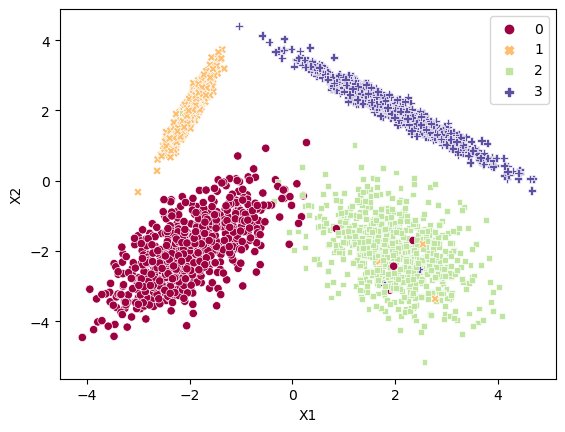

In [24]:
#X, Y = datasets.make_circles(n_samples=3000, shuffle=True, noise=0.04)
X, Y = datasets.make_classification(n_samples=3000, n_features=2, n_classes=4, n_informative=2, n_redundant=0, 
                                    n_clusters_per_class=1, class_sep=2.0)
draw_data(X, Y)

In [25]:
X_train, X_test, y_train, y_real = train_test_split(X, Y, test_size=0.2)

In [26]:
y_train = transform_y(y_train)
y_test = transform_y(y_real)

# Create Network and fit it

In [27]:
input_layer = Input_Layer(n=2)
h1 = Layer(n=23, activation='tanh', i_n=input_layer.n)
h2 = Layer(n=31, activation='tanh', i_n=h1.n)
out_layer = Layer(n=4, activation='sigmoid', i_n=h2.n)

network = Network([input_layer, h1, h2, out_layer], ErrorFunc())

Progress: 0% 20% 40% 60% 80% 100%


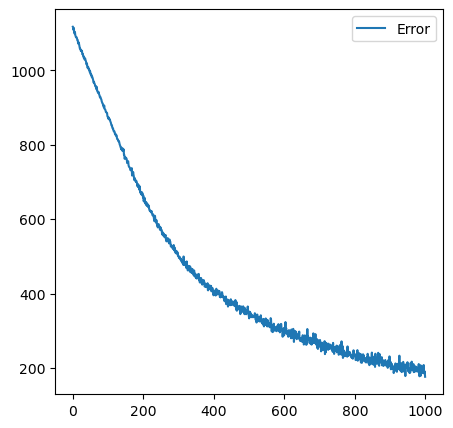

In [28]:
network.stohastic_fit(X_train, y_train, lr=0.01, batch_size=415)

In [29]:
error_func = ErrorFunc()
error = 0.0

predicts, vect = network.predict(X_test)
error += error_func.calculate_error(vect, y_test.T)
    
print('Erorr value = {}'.format(error))

print('Accuracy_Score = {}'.format(accuracy_score(predicts, y_real)))
print('Precision_Score = {}'.format(precision_score(predicts, y_real, average='macro')))

print('Recall_Score = {}'.format(recall_score(predicts, y_real, average='macro')))

Erorr value = 271.2967906781859
Accuracy_Score = 0.985
Precision_Score = 0.9849809963151069
Recall_Score = 0.984924110636676


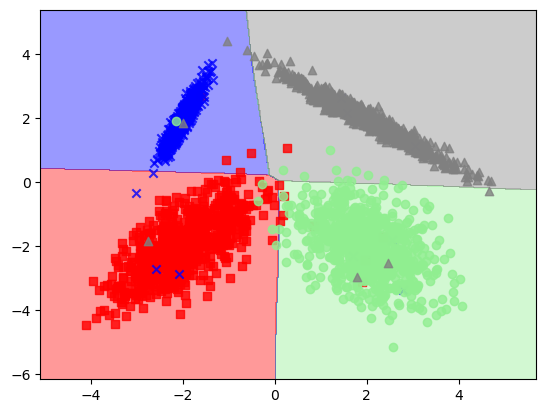

In [30]:
plot_decision_regions(X, Y, network, resolution=0.02, draw_samples=True)

## Let's try on dataset with digits

In [222]:
digits = load_digits()

In [223]:
X_train, X_test, y_train_real, y_real = train_test_split(digits['data'], digits['target'], shuffle=True, test_size=0.3)

In [224]:
y_train = transform_y(y_train_real)
y_test = transform_y(y_real)

In [225]:
# Create Network Architecture
inpt_layer = Input_Layer(n=X_train.shape[1])
h1 = Layer(n=17, i_n=inpt_layer.n)
h2 = Layer(n=22, activation='tanh', i_n=h1.n)
out_layer = Layer(n=10, activation='softmax', i_n=h2.n)

network = Network([inpt_layer, h1, h2, out_layer])

Epoch #1: 0% 20% 40% 60% 80% 100%
Epoch #2: 0% 20% 40% 60% 80% 100%
Epoch #3: 0% 20% 40% 60% 80% 100%
Epoch #4: 0% 20% 40% 60% 80% 100%
Epoch #5: 0% 20% 40% 60% 80% 100%
Epoch #6: 0% 20% 40% 60% 80% 100%
Epoch #7: 0% 20% 40% 60% 80% 100%
Epoch #8: 0% 20% 40% 60% 80% 100%
Epoch #9: 0% 20% 40% 60% 80% 100%
Epoch #10: 0% 20% 40% 60% 80% 100%
Epoch #11: 0% 20% 40% 60% 80% 100%
Epoch #12: 0% 20% 40% 60% 80% 100%
Epoch #13: 0% 20% 40% 60% 80% 100%
Epoch #14: 0% 20% 40% 60% 80% 100%
Epoch #15: 0% 20% 40% 60% 80% 100%
Epoch #16: 0% 20% 40% 60% 80% 100%
Epoch #17: 0% 20% 40% 60% 80% 100%
Epoch #18: 0% 20% 40% 60% 80% 100%
Epoch #19: 0% 20% 40% 60% 80% 100%
Epoch #20: 0% 20% 40% 60% 80% 100%
Epoch #21: 0% 20% 40% 60% 80% 100%
Epoch #22: 0% 20% 40% 60% 80% 100%
Epoch #23: 0% 20% 40% 60% 80% 100%
Epoch #24: 0% 20% 40% 60% 80% 100%
Epoch #25: 0% 20% 40% 60% 80% 100%
Epoch #26: 0% 20% 40% 60% 80% 100%
Epoch #27: 0% 20% 40% 60% 80% 100%
Epoch #28: 0% 20% 40% 60% 80% 100%
Epoch #29: 0% 20% 40% 60% 80%

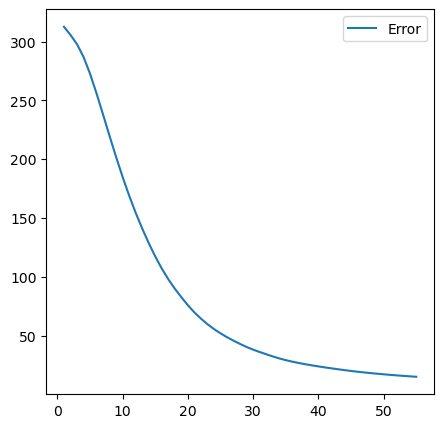

In [226]:
network.fit(X_train, y_train, batch_size=95, n_epoch=55, lr=0.1)

In [227]:
# results on TRAIN DATA
predicts, vect = network.predict(X_train)

print('Accuracy_Score = {}'.format(accuracy_score(y_train_real, predicts)))
print('Precision_Score = {}'.format(precision_score(y_train_real, predicts, average='macro')))
print('Recall_Score = {}'.format(recall_score(y_train_real, predicts, average='macro')))

#Confusion matrix
cm = confusion_matrix(y_train_real, predicts, labels=digits['target_names'])
pd.DataFrame(cm)

Accuracy_Score = 0.9920445505171042
Precision_Score = 0.992155099684336
Recall_Score = 0.9921399458195536


,0,1,2,3,4,5,6,7,8,9
0,130,0,0,0,0,0,0,0,0,0
1,0,128,0,0,0,0,0,0,0,0
2,0,0,121,0,0,0,0,0,0,0
3,0,0,0,127,0,0,0,0,0,1
4,0,1,0,0,134,0,0,0,1,0
5,0,0,0,0,0,121,0,0,0,1
6,0,0,0,0,1,0,118,0,0,0
7,0,0,0,0,0,0,0,122,0,0
8,0,2,0,0,0,0,0,0,115,0
9,0,0,1,1,0,0,0,0,1,131


In [228]:
# results on TRAIN DATA
predicts, vect = network.predict(X_test)

print('Accuracy_Score = {}'.format(accuracy_score(y_real, predicts)))
print('Precision_Score = {}'.format(precision_score(y_real, predicts, average='macro')))
print('Recall_Score = {}'.format(recall_score(y_real, predicts, average='macro')))

#Confusion matrix
cm = confusion_matrix(y_real, predicts, labels=digits['target_names'])
pd.DataFrame(cm)

Accuracy_Score = 0.9648148148148148
Precision_Score = 0.9662201311136831
Recall_Score = 0.9648956844187337


,0,1,2,3,4,5,6,7,8,9
0,47,0,0,0,0,1,0,0,0,0
1,0,52,0,0,0,0,0,0,2,0
2,0,0,55,1,0,0,0,0,0,0
3,0,0,3,50,0,0,0,0,1,1
4,0,0,0,0,43,0,0,1,0,1
5,0,0,1,0,0,58,0,0,0,1
6,0,1,0,0,0,0,60,0,1,0
7,0,0,0,0,0,0,0,57,0,0
8,0,1,1,0,0,1,0,0,54,0
9,0,0,0,0,0,0,0,0,1,45


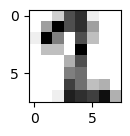

Network thinks that it is number = 2
In fact it is = 2


In [231]:
N = 566

predict = network.predict(digits['data'][N:N+1])[0][0]

plt.figure(1, figsize=(1.2, 1.2))
plt.imshow(digits.images[N], cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

print('Network thinks that it is number = {}'.format(predict))
print('In fact it is = {}'.format((digits.target[N])))

# MNIST

In [232]:
(X_train, y_real_train), (X_test, y_real) = mnist.load_data()

In [233]:
X_train = X_train.reshape((X_train.shape[0], -1)) / 255.0
X_test = X_test.reshape((X_test.shape[0], -1)) / 255.0
y_train = transform_y(y_real_train)
y_test = transform_y(y_real)

In [236]:
# Create Network Architecture
inpt_layer = Input_Layer(n=X_train.shape[1])
h1 = Layer(n=189, i_n=inpt_layer.n)
h2 = Layer(n=116, activation='sigmoid', i_n=h1.n)
h3 = Layer(n=199, i_n=h2.n)
h4 = Layer(n=107, activation='tanh', i_n=h3.n)
out_layer = Layer(n=10, activation='softmax', i_n=h4.n)

network = Network([inpt_layer, h1, h2, h3, h4, out_layer])

Epoch #1: 0% 20% 40% 60% 80% 100%
Epoch #2: 0% 20% 40% 60% 80% 100%
Epoch #3: 0% 20% 40% 60% 80% 100%
Epoch #4: 0% 20% 40% 60% 80% 100%
Epoch #5: 0% 20% 40% 60% 80% 100%
Epoch #6: 0% 20% 40% 60% 80% 100%
Epoch #7: 0% 20% 40% 60% 80% 100%
Epoch #8: 0% 20% 40% 60% 80% 100%
Epoch #9: 0% 20% 40% 60% 80% 100%
Epoch #10: 0% 20% 40% 60% 80% 100%
Epoch #11: 0% 20% 40% 60% 80% 100%
Epoch #12: 0% 20% 40% 60% 80% 100%
Epoch #13: 0% 20% 40% 60% 80% 100%
Epoch #14: 0% 20% 40% 60% 80% 100%
Epoch #15: 0% 20% 40% 60% 80% 100%
Epoch #16: 0% 20% 40% 60% 80% 100%
Epoch #17: 0% 20% 40% 60% 80% 100%
Epoch #18: 0% 20% 40% 60% 80% 100%
Epoch #19: 0% 20% 40% 60% 80% 100%
Epoch #20: 0% 20% 40% 60% 80% 100%
Epoch #21: 0% 20% 40% 60% 80% 100%
Epoch #22: 0% 20% 40% 60% 80% 100%
Epoch #23: 0% 20% 40% 60% 80% 100%
Epoch #24: 0% 20% 40% 60% 80% 100%
Epoch #25: 0% 20% 40% 60% 80% 100%
Epoch #26: 0% 20% 40% 60% 80% 100%
Epoch #27: 0% 20% 40% 60% 80% 100%
Epoch #28: 0% 20% 40% 60% 80% 100%
Epoch #29: 0% 20% 40% 60% 80%

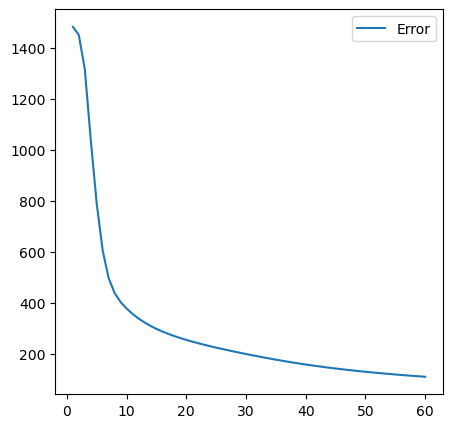

In [237]:
network.fit(X_train, y_train, lr=0.1, batch_size=455, n_epoch=60)
#network.stohastic_fit(X_train, y_train, lr=0.1, batch_size=115, n_rounds=50, e_norm=1.0)

#### Metrics on train data

In [238]:
predicts, vect = network.predict(X_train)

print('Accuracy_Score = {}'.format(accuracy_score(y_real_train, predicts)))
print('Precision_Score = {}'.format(precision_score(y_real_train, predicts, average='macro')))
print('Recall_Score = {}'.format(recall_score(y_real_train, predicts, average='macro')))

Accuracy_Score = 0.9598166666666667
Precision_Score = 0.9596350927901771
Recall_Score = 0.9596049485574193


#### Metrics on test data

In [239]:
predicts, vect = network.predict(X_test)

print('Accuracy_Score = {}'.format(accuracy_score(y_real, predicts)))
print('Precision_Score = {}'.format(precision_score(y_real, predicts, average='macro')))
print('Recall_Score = {}'.format(recall_score(y_real, predicts, average='macro')))

Accuracy_Score = 0.9563
Precision_Score = 0.9559399146233638
Recall_Score = 0.9560691257464875


In [240]:
#Confusion matrix
cm = confusion_matrix(y_real, predicts, labels=np.arange(10))
pd.DataFrame(cm)

,0,1,2,3,4,5,6,7,8,9
0,968,0,1,2,0,5,2,1,1,0
1,0,1119,2,2,0,1,3,2,6,0
2,12,4,970,11,4,0,4,9,15,3
3,0,0,6,964,0,19,0,9,10,2
4,1,0,2,0,938,0,7,2,1,31
5,4,1,1,4,3,861,2,2,10,4
6,12,3,2,0,8,22,907,0,4,0
7,3,10,13,5,2,0,0,970,1,24
8,4,3,3,15,6,13,5,4,913,8
9,8,4,1,6,19,7,0,7,4,953


## Try Conv2D

In [23]:
(X_train, y_real_train), (X_test, y_real) = mnist.load_data()

In [24]:
#X_train = X_train[:45_000]
#y_real_train = y_real_train[:45_000]

In [25]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [26]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1], X_test.shape[2]))

In [27]:
y_train = transform_y(y_real_train)
y_test = transform_y(y_real)

In [257]:
input_layer = Input_Layer(i_n_shape=(1, 28, 28))
conv_h1 = Conv2D(n_kernel=32, k_shape=(1, 3, 3), i_n_shape=input_layer.i_n, activation='linear')
pooler_p1 = MaxPooler(conv_h1.out_shape, (2, 2))
conv_h2 = Conv2D(n_kernel=16, k_shape=(32, 3, 3), i_n_shape=pooler_p1.out_shape, activation='linear')
pooler_p2 = MaxPooler(conv_h2.out_shape, (2, 2))
flatten = Flatten(pooler_p2.out_shape)
out_layer = Layer(n=10, activation='softmax', i_n=flatten.n)

network = Network([input_layer, conv_h1, pooler_p1, conv_h2, pooler_p2, flatten, out_layer])

Epoch #1: 0% 20% 40% 60% 80% 100%
Epoch #2: 0% 20% 40% 60% 80% 100%
Epoch #3: 0% 20% 40% 60% 80% 100%
Epoch #4: 0% 20% 40% 60% 80% 100%
Epoch #5: 0% 20% 40% 60% 80% 100%
Epoch #6: 0% 20% 40% 60% 80% 100%


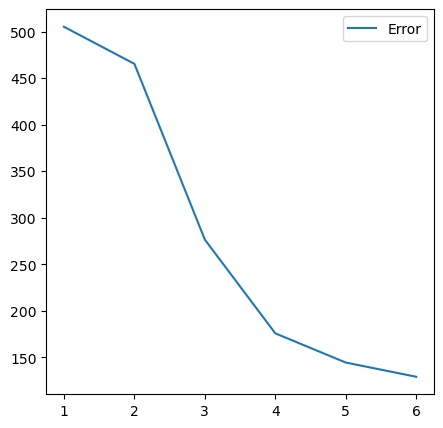

In [258]:
#network.stohastic_fit(X_train, y_train, lr=0.001, batch_size=315, n_rounds=500)
network.fit(X_train, y_train, lr=0.01, batch_size=155, n_epoch=6)

In [259]:
predicts, vect = network.predict(X_train)

print('Accuracy_Score = {}'.format(accuracy_score(y_real_train, predicts)))
print('Precision_Score = {}'.format(precision_score(y_real_train, predicts, average='macro')))
print('Recall_Score = {}'.format(recall_score(y_real_train, predicts, average='macro')))

Accuracy_Score = 0.8555833333333334
Precision_Score = 0.8563736075575872
Recall_Score = 0.8541344603335576


In [260]:
cm = confusion_matrix(y_real_train, predicts, labels=np.arange(10))
pd.DataFrame(cm)

,0,1,2,3,4,5,6,7,8,9
0,5532,2,35,21,9,193,72,11,29,19
1,0,6460,59,42,2,55,5,12,93,14
2,87,209,4855,140,110,97,147,96,160,57
3,31,55,220,4697,7,635,48,74,205,159
4,11,31,34,7,4978,36,119,25,82,519
5,70,92,63,226,85,4480,91,47,165,102
6,59,91,94,8,74,224,5300,11,50,7
7,34,100,79,33,50,60,4,5432,64,409
8,23,216,66,205,51,280,62,30,4685,233
9,66,76,27,97,287,78,4,296,102,4916


In [261]:
predicts, vect = network.predict(X_test)

print('Accuracy_Score = {}'.format(accuracy_score(y_real, predicts)))
print('Precision_Score = {}'.format(precision_score(y_real, predicts, average='macro')))
print('Recall_Score = {}'.format(recall_score(y_real, predicts, average='macro')))

Accuracy_Score = 0.8621
Precision_Score = 0.8627184623085643
Recall_Score = 0.8607386547125302


In [262]:
cm = confusion_matrix(y_real, predicts, labels=np.arange(10))
pd.DataFrame(cm)

,0,1,2,3,4,5,6,7,8,9
0,931,0,3,1,0,29,13,2,1,0
1,0,1098,8,8,0,3,2,1,15,0
2,12,38,841,18,16,21,22,17,40,7
3,7,1,26,786,0,107,4,21,38,20
4,1,2,3,0,850,10,22,5,13,76
5,9,8,8,40,14,740,18,12,33,10
6,17,7,11,0,18,43,851,2,8,1
7,5,23,21,1,8,5,0,880,15,70
8,5,19,6,33,11,54,11,13,786,36
9,12,14,3,11,48,19,0,32,12,858


In [264]:
# Results

def check_images(start, end, X_data, y_data, network):
    for N in range(start, end):

        predict = network.predict(X_data[N:N+1])[0][0]

        plt.figure(1, figsize=(0.7, 0.7))
        plt.imshow(X_data[N][0], cmap=plt.get_cmap('gray'))
        plt.show()

        print('Network thinks that it is number = {}'.format(predict))
        print('In fact it is = {}'.format(y_data[N]))

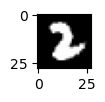

Network thinks that it is number = 2
In fact it is = 2


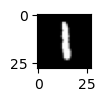

Network thinks that it is number = 1
In fact it is = 1


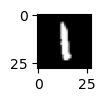

Network thinks that it is number = 1
In fact it is = 1


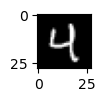

Network thinks that it is number = 4
In fact it is = 4


In [271]:
check_images(3229, 3233, X_test, y_real, network)

In [203]:
import numpy as np

from math import pi, sin, cos, sqrt, asin
from scipy.stats import uniform
from sklearn.metrics.pairwise import haversine_distances
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

In [204]:
R = 6.371

def haversine(p1, p2):
    
    d_lon = p1[0] - p2[0]
    d_lat = p1[1] - p2[1]
    
    tmp = sin(d_lat / 2)**2 + cos(p1[1]) * cos(p2[1]) * sin(d_lon / 2)**2
    tmp = 2 * asin(sqrt(tmp))
    
    return R * tmp

def generate_geodata(n_size):
    
    lon = uniform.rvs(loc=-pi, scale=2*pi, size=n_size)
    lat = uniform.rvs(loc=-pi/2, scale=pi, size=n_size)
    
    return np.vstack([lon, lat]).T

In [233]:
N = 500_000

xx = generate_geodata(N)
yy = generate_geodata(N)

distances = np.array(list(map(lambda p1, p2: haversine(p1, p2), xx, yy))).reshape(-1, 1)
data = np.hstack([xx, yy])

In [234]:
X_train, X_test, y_train, y_test = train_test_split(data, distances, test_size=0.7)

In [235]:
inpt = Input_Layer(n=4)
h1 = Layer(n=232, i_n=inpt.n, activation='tanh')
h2 = Layer(n=334, i_n=h1.n, activation='tanh')
h3 = Layer(n=1, i_n=h2.n, activation='linear')

network = Network([inpt, h1, h2, h3], error_func=SE_ErrorFunc())

Epoch #1: 0% 20% 40% 60% 80% 100%
Epoch #2: 0% 20% 40% 60% 80% 100%
Epoch #3: 0% 20% 40% 60% 80% 100%
Epoch #4: 0% 20% 40% 60% 80% 100%
Epoch #5: 0% 20% 40% 60% 80% 100%
Epoch #6: 0% 20% 40% 60% 80% 100%
Epoch #7: 0% 20% 40% 60% 80% 100%
Epoch #8: 0% 20% 40% 60% 80% 100%
Epoch #9: 0% 20% 40% 60% 80% 100%
Epoch #10: 0% 20% 40% 60% 80% 100%
Epoch #11: 0% 20% 40% 60% 80% 100%
Epoch #12: 0% 20% 40% 60% 80% 100%
Epoch #13: 0% 20% 40% 60% 80% 100%
Epoch #14: 0% 20% 40% 60% 80% 100%
Epoch #15: 0% 20% 40% 60% 80% 100%
Epoch #16: 0% 20% 40% 60% 80% 100%
Epoch #17: 0% 20% 40% 60% 80% 100%
Epoch #18: 0% 20% 40% 60% 80% 100%
Epoch #19: 0% 20% 40% 60% 80% 100%
Epoch #20: 0% 20% 40% 60% 80% 100%


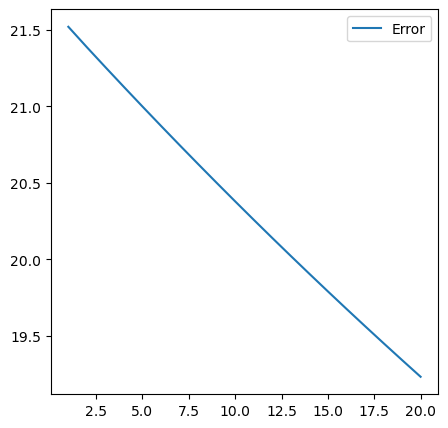

In [246]:
network.fit(X_train, y_train, n_epoch=20, lr=0.002, batch_size=455)

In [247]:
predicts = network.predict(X_test)[0]
predicts_train = network.predict(X_train)[0]

In [248]:
print('Mean Squared Error for test data = {}'.format(mean_squared_error(y_test, predicts)))
print('Mean Squared Error for train data = {}'.format(mean_squared_error(y_train, predicts_train)))

Mean Squared Error for test data = 0.04316668005529845
Mean Squared Error for train data = 0.04208605032877891
